Predict the evolution of the white light CME FOV using a parametrized Neural ODE. 
Regular PNODE - expt ID 20376 - does well after a 140 odd epochs.
VAE PNODE - expt ID 78555 - does really well! (1e-4 train and val loss orders after 150 epochs).

After that we can do more experiments with quadratic term added to the ODE in the latent space.

We also need plots of latent space LOL.

In [1]:
args = {
    # "niters": 1000,
    # "niters": 4000,
    "niters":150,
    "lr": 1e-3,
    "save": "experiments/",
    "load": 78555,
    "r": 1991,
    "node-layers": 2,
    "mlp-layers": 1,
    "latents": 8,  # 68818 has 8 latent dims
    # "latents": 20, # 44467 expt ID, else only 8 dims
    "units": 50,
    # "test_mode": "t5p4",
    # "test_mode": "t12v4p7",
    # "resize_dims": (32, 128),
    "resize_dims": (16, 64),
    "param_scaling": [1, 1],
    "warm_start": 20376,
    "do_warm_start": False,
    "quadratic": False,
    "loss": "smooth_l1",
    "l2int": 0.1, # "int_t ||f||_2"
    "JFrobint": 0.1, # "int_t ||df/dx||_F",
    "batch_size": 4,
    "steps_to_predict": 8,
    "sampled_ics": 4,
    "dropout":False
    # "loss": "mae"
    # "test_mode" can take values "t2p1, t4p1" for now (number of training vs val and test sims)
}

In [2]:
import sys

In [3]:
import torch
import torch.nn 
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T
# from sunpy.visualization import colormaps as cm    

import node_utils as nut
import data_utils as dut

/home/ajivani/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
import time
import datetime
import argparse
import numpy as np
# import pandas as pd
from random import SystemRandom

from rich.progress import track
import tqdm

adjoint=True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

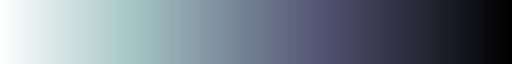

In [5]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

In [6]:
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)

In [9]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [10]:
import pandas as pd

In [11]:
arr_times_data = pd.read_csv("./data_surrogate/UShift_CME3_120runs.csv")
arr_times_data = arr_times_data.dropna()

data_sim_ids = arr_times_data['SIMID'].to_numpy()
data_arr_time = arr_times_data['Tshock_sim'].to_numpy()
data_shifts = arr_times_data['shift'].to_numpy()

In [12]:
data_sim_ids

array([  1,   3,   4,   5,   7,   9,  10,  11,  12,  13,  15,  16,  17,
        18,  19,  20,  21,  23,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120])

In [13]:
num_sim = len(data_sim_ids)
print(num_sim)

train_frac, valid_frac, test_frac = 0.6, 0.2, 0.2

113


In [14]:
generator1 = torch.Generator().manual_seed(2024)
train_valid_test = random_split(data_sim_ids, 
                                [train_frac, valid_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)

In [15]:
# validation_dir = "./validation_data"
# validation_file = os.path.join(validation_dir, "CR2161_validation_PolarTensor.npy")
# sim_file = os.path.join(validation_dir, "CR2161_SimID4edge_validation.npy")
# param_file = os.path.join(validation_dir, "params_2161_validation.txt")

In [16]:
# np.loadtxt(param_file)

In [17]:
# all_sim_ids = np.linspace(1, 24, 24, dtype=int)
# successful_sims = np.array([int(re.search(r'\d+', f).group()) for f in np.load(sim_file)])
# successful_sims

In [18]:
train_idx = np.array(train_valid_test[0].indices)
val_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

In [19]:
train_idx

array([  7,  43,  63,  33,  38,  73,  66,  20,  46,  80,  32,  21,  52,
        91, 101, 105,  35, 109,  19,  61,  82,  72,  92,  81,  90,   9,
        85,  39,  70,  40,  22,  45,  95,  24,  12,  97,   5,  67,  84,
        74, 110,  30,  71, 100,  37,  98, 102,  94,  57,  53,  75,  83,
       107,  42,  68,  69,  15,  59,  26,  10, 103, 112,  14,  56,  29,
       111,  87,  49])

In [20]:
data_sim_ids[train_idx]

array([ 11,  50,  71,  40,  45,  81,  74,  27,  53,  88,  39,  28,  59,
        99, 109, 113,  42, 117,  26,  68,  90,  80, 100,  89,  98,  13,
        93,  46,  78,  47,  29,  52, 103,  31,  17, 105,   9,  75,  92,
        82, 118,  37,  79, 108,  44, 106, 110, 102,  64,  60,  83,  91,
       115,  49,  76,  77,  20,  66,  33,  15, 111, 120,  19,  63,  36,
       119,  95,  56])

In [21]:
data_sim_ids

array([  1,   3,   4,   5,   7,   9,  10,  11,  12,  13,  15,  16,  17,
        18,  19,  20,  21,  23,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120])

In [22]:
train_sims = data_sim_ids[train_idx] - 1
val_sims = data_sim_ids[val_idx] - 1
test_sims = data_sim_ids[test_idx] - 1

In [23]:
train_sims, val_sims, test_sims

(array([ 10,  49,  70,  39,  44,  80,  73,  26,  52,  87,  38,  27,  58,
         98, 108, 112,  41, 116,  25,  67,  89,  79,  99,  88,  97,  12,
         92,  45,  77,  46,  28,  51, 102,  30,  16, 104,   8,  74,  91,
         81, 117,  36,  78, 107,  43, 105, 109, 101,  63,  59,  82,  90,
        114,  48,  75,  76,  19,  65,  32,  14, 110, 119,  18,  62,  35,
        118,  94,  55]),
 array([  3, 100,  20,  95,  22,   9,  42, 111,  61,  29,  54, 106,  93,
         50,  86,  31, 115,  85,  57,  64,  72,  68,  60]),
 array([103,  11,  96, 113,  71,   6,  33,  83,  84,  34,  56,  40,   2,
         47,  17,   0,  37,  66,  24,   4,  53,  15]))

In [24]:
raw_params = pd.read_csv("./data_surrogate/params_2192_120runs.csv")
raw_params = raw_params[["BStrength", "OrientationCme", "ApexHeight", "iHelicity"]]
raw_params

,BStrength,OrientationCme,ApexHeight,iHelicity
0,5.0417,347.475,0.8505,-1
1,5.1250,330.225,0.7196,1
2,6.7917,380.475,0.7482,1
3,5.3750,342.225,0.9123,-1
4,5.2917,322.725,0.8719,1
...,...,...,...,...
115,14.6250,300.225,0.6911,1
116,14.7083,371.475,0.9337,1
117,14.7917,348.225,0.7743,1
118,14.8750,312.975,0.7363,-1


In [25]:
raw_params_retained = raw_params.to_numpy()[data_sim_ids - 1, :]
raw_params_retained.shape

(113, 4)

In [26]:
train_params_raw = raw_params_retained[train_idx, :]
val_params_raw = raw_params_retained[val_idx, :]
test_params_raw = raw_params_retained[test_idx, :]

In [27]:
train_params_raw.shape

(68, 4)

In [28]:
# Scaling?
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_params_raw)
train_params_scaled = scaler.transform(train_params_raw)
val_params_scaled = scaler.transform(val_params_raw)
test_params_scaled = scaler.transform(test_params_raw)

In [29]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 50 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1

# scale time appropriately
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)

In [30]:
tMinIdx, tMaxIdx

(50, 89)

In [31]:
raw_data = np.load("./data_surrogate/CR2192_120runs_C3_ratio_PolarTensor.npy")

In [32]:
train_data_raw = raw_data[:, :, :, train_sims]
val_data_raw = raw_data[:, :, :, val_sims]
test_data_raw = raw_data[:, :, :, test_sims]

In [33]:
train_data_raw.min(), val_data_raw.min(), test_data_raw.min()

(0.799298967364635, 0.812880930443961, 0.8405320567290443)

In [34]:
resize_dims = args["resize_dims"]
resize_dims

(16, 64)

In [35]:
input_dim = int(resize_dims[0] * resize_dims[1])
input_dim

1024

In [36]:
train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))
    
val_data_resized = T.Resize(size=resize_dims,
                                antialias=True
                                )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))
    
test_data_resized = T.Resize(size=resize_dims,
                                antialias=True
                                )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [37]:
train_data_resized.min(), val_data_resized.min(), test_data_resized.min()

(tensor(0.8940), tensor(0.8993), tensor(0.9152))

In [38]:
max_train = torch.max(train_data_resized).item()
min_train = torch.min(train_data_resized).item()
max_train, min_train

(1.5, 0.8940430879592896)

In [39]:
train_data = (train_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)

In [40]:
train_data.shape

torch.Size([68, 40, 16, 64])

In [41]:
def final_loss(recon_loss, beta, mu, logvar):
    BCE = recon_loss
    if beta == 0:
        return BCE
    else:
        KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        return BCE + beta*KLD

In [42]:
# Plot snapshots of all data - verify that the IC has information we can use!!

In [43]:
def plotAndSaveSnapshots(dataset, simID,
                         type="train",
                         saveDir="./scratch_figs/ic_figs", 
                         vmin=0.89,
                         vmax=1.5
                        ):
    """
    Take in simID and a dataset. Plot the first snapshot of the dataset and save 
    as figure in a scratch_fig dir. Dataset is 4D, shaped as nSims x nTimes x nx
    x ny!
    """
    snapshot_to_plot = dataset[simID, 0, :, :]
    im = plt.imshow(snapshot_to_plot,
                    origin="lower",
                    cmap="viridis",
                    # vmin=vmin,
                    # vmax=vmax
                   )
    
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    plt.title("Sim Idx {}".format(simID))
    
    nut.makedirs(saveDir)
    plt.savefig(os.path.join(saveDir, "Ic_{}_sim_{:03d}.png".format(type, simID)))
    
    plt.close()
    

In [44]:
# for i in range(train_data.shape[0]):
#     print("Processed sim ", i)
#     plotAndSaveSnapshots(train_data, i, type="train")
    
# for i in range(test_data.shape[0]):
#     print("Processed sim ", i)
#     plotAndSaveSnapshots(test_data, i, type="test")

In [45]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

In [46]:
train_params_ts = np.repeat(train_params_scaled.reshape((train_params_scaled.shape[0], 
                                                         train_params_scaled.shape[1], 1)), 
                            nTimesteps, axis=2)
val_params_ts = np.repeat(val_params_scaled.reshape((val_params_scaled.shape[0], 
                                                     val_params_scaled.shape[1], 1)), 
                          nTimesteps, axis=2)
test_params_ts = np.repeat(test_params_scaled.reshape((test_params_scaled.shape[0], 
                                                       test_params_scaled.shape[1], 1)), 
                           nTimesteps, axis=2)

In [47]:
train_all = torch.cat((train_snaps, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [48]:
tpredict

tensor([0.0000, 0.0256, 0.0513, 0.0769, 0.1026, 0.1282, 0.1538, 0.1795, 0.2051,
        0.2308, 0.2564, 0.2821, 0.3077, 0.3333, 0.3590, 0.3846, 0.4103, 0.4359,
        0.4615, 0.4872, 0.5128, 0.5385, 0.5641, 0.5897, 0.6154, 0.6410, 0.6667,
        0.6923, 0.7179, 0.7436, 0.7692, 0.7949, 0.8205, 0.8462, 0.8718, 0.8974,
        0.9231, 0.9487, 0.9744, 1.0000])

In [49]:
# create lists
train_dataset = [(train_all[i:(i+1), :, :], tpredict) for i in range(train_all.shape[0])]
val_dataset = [(val_all[i:(i+1), :, :], tpredict) for i in range(val_all.shape[0])]
test_dataset = [(test_all[i:(i+1), :, :], tpredict) for i in range(test_all.shape[0])]

In [50]:
# data_obj = dut.parse_datasets2(validation_file, 
#                               sim_file, 
#                               param_file, 
#                               args, 
#                               device)

In [51]:
def collate_fn_wl(batch, input_dim, device):
    data = torch.zeros([len(batch), 1, batch[0][0].shape[2]]).to(device)
    target = torch.zeros([len(batch), batch[0][0].shape[1], input_dim]).to(device)
    
    for b, (snap, ts) in enumerate(batch):
        data[b, 0, :] = snap[:, 0, :]
        target[b, :, :] = snap[:, :, :input_dim]
        
        data_ts = ts[:1]
        
    data_dict = {"observed_data": data.permute(1, 0, 2),
                "observed_tp": data_ts,
                "data_to_predict": target,
                # "tp_to_predict": ts
                }
    
    return data_dict

In [52]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = 4, 
                              shuffle=False,
                              # num_workers=1, 
                              collate_fn = lambda batch: collate_fn_wl(batch, input_dim, device))
    

val_dataloader = DataLoader(val_dataset,
                        batch_size = len(val_dataset),
                        shuffle=False,
                        # num_workers=1,
                        collate_fn = lambda batch: collate_fn_wl(batch, input_dim, device))

test_dataloader = DataLoader(test_dataset,
                        batch_size = len(test_dataset),
                        shuffle=False,
                        # num_workers=1,
                        collate_fn = lambda batch: collate_fn_wl(batch, input_dim, device))

In [53]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(17, 1, 1)

In [54]:
# Sanity checks - plot the initial condition and the full dataset for all val sims.

def plotICAndTarget(dataloader_object, 
                    type_dl="val", 
                    param_dim=4,
                    savedir="./scratch_figs/dataloader_figs"):
    time_idx_to_plot = [0, 10, 20, 30, -1]
    bd = dut.get_next_batch(dut.inf_generator(dataloader_object))
    
    ip_dims = bd["observed_data"].shape[2] - param_dim
    
    nsims = bd["observed_data"].shape[1]
    ntimes = bd["data_to_predict"].shape[1]
    
    ic_np = bd["observed_data"].squeeze(0).cpu().detach().numpy()
    dp_np = bd["data_to_predict"].cpu().detach().numpy()
    
    # print(dp_np[:, 0, :].shape)
    assert np.all(ic_np[:, :ip_dims] == dp_np[:, 0, :])
    
    
    
    for i in range(nsims):
        print("Processing for sim ", i)
        fig, ax = plt.subplots(nrows=len(time_idx_to_plot), ncols=1, figsize=(4, 10))
        for row in range(len(time_idx_to_plot)):
            im = ax[row].imshow(dp_np[i, time_idx_to_plot[row], :].reshape((16, 64)),
                                origin="lower",
                                cmap="viridis"
                               )
            fig.colorbar(im, fraction=0.046, pad=0.04, ax=ax[row])                         
                                      
        fig.suptitle("Raw data sim ID {:03d}".format(i))
        plt.tight_layout()
        
        nut.makedirs(savedir)
        plt.savefig(os.path.join(savedir, 
                                 "wl_sim_{:03d}_{}.png".format(i,
                                                               type_dl
                                                              )
                                ))
        plt.close()

In [55]:
# plotICAndTarget(val_dataloader)

In [56]:
model = nut.VPNODE_Conv(input_dim=input_dim, 
                       latent_dim=args["latents"], 
                       param_dim=4, 
                       device=device,
                       n_layers=args["node-layers"],
                       n_units=args["units"],
                       quadratic=args["quadratic"],
                       dropout=args["dropout"],
                       resize_dims=args["resize_dims"]).to(device)


pEncoder = nut.count_parameters(model.encoder) + nut.count_parameters(model.fc_mu) + nut.count_parameters(model.fc_log_var)
pPNODE = nut.count_parameters(model.pnode)
pDecoder = nut.count_parameters(model.decoder_mlp) + nut.count_parameters(model.decoder_conv)

print("Total Number of Parameters: ")
print(pEncoder + pPNODE + pDecoder)

nut.makedirs(os.path.join(os.getcwd(), "logs"))
logdir = os.path.join(os.getcwd(), "logs")

exptdir = os.path.join(os.getcwd(), args["save"])
nut.makedirs(exptdir)
# nut.makedirs("./model_stopping")

if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    if args["do_warm_start"] == True:
        experimentID = args["warm_start"]
        print("Warm starting previous experiment")
    else:
        experimentID = int(SystemRandom().random()*100000)
        print("Starting new experiment")

print("Experiment ID: ")
print(experimentID)

ckpt_path = os.path.join(exptdir, "experiment_" + str(experimentID) + '.ckpt')

print("Checkpoint Path: ")
print(ckpt_path)

logger = dut.get_logger(logpath=os.path.join(logdir, "expt_normalized_pnode_images_2.log"))
logger

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pEncoder + pPNODE + pDecoder))
logger.info(args)
logger.info("Building with Variational Loss")
logger.info("Checkpoint Path")
logger.info(ckpt_path)
logger.info("Input Dim: ")
logger.info(input_dim)
logger.info("Param Dim: ")
logger.info(4)
logger.info("Latent Dim: ")
logger.info(args["latents"])
logger.info(device)

/home/ajivani/WLROM_new/WhiteLight
VPNODE_Conv(
  (regularize): Identity()
  (encoder): Sequential(
    (0): ZeroPad2d((7, 8, 7, 8))
    (1): Conv2d(1, 4, kernel_size=(16, 16), stride=(2, 2))
    (2): ELU(alpha=1.0)
    (3): ZeroPad2d((3, 4, 3, 4))
    (4): Conv2d(4, 8, kernel_size=(8, 8), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): ZeroPad2d((1, 2, 1, 2))
    (7): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
    (8): ELU(alpha=1.0)
    (9): ZeroPad2d((0, 1, 0, 1))
    (10): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (11): ELU(alpha=1.0)
    (12): ZeroPad2d((0, 0, 0, 0))
    (13): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    (14): ELU(alpha=1.0)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=128, out_features=64, bias=True)
    (17): ELU(alpha=1.0)
    (18): Identity()
  )
  (pnode): ODENet(
    (odenet): Sequential(
      (0): Linear(in_features=12, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=

Using regular PNODE
Total Number of Parameters: 
72604
Loading experiment
Experiment ID: 
78555
Checkpoint Path: 
/home/ajivani/WLROM_new/WhiteLight/experiments/experiment_78555.ckpt


In [57]:
ckpt_path

'/home/ajivani/WLROM_new/WhiteLight/experiments/experiment_78555.ckpt'

In [58]:
args["lr"]

0.001

In [59]:
import copy

In [60]:
# encoder = nn.Sequential(nn.ZeroPad2d((7,8,7,8)),
#                 nn.Conv2d(1,4,16,stride=(2,2),padding=(0,0)),
#                 nn.ELU(),
#                 nn.ZeroPad2d((3,4,3,4)),
#                 nn.Conv2d(4,8,8,stride=(2,2),padding=(0,0)),
#                 nn.ELU(),
#                 nn.ZeroPad2d((1,2,1,2)),
#                 nn.Conv2d(8,16,4,stride=(2,2),padding=(0,0)),
#                 nn.ELU(),
#                 nn.ZeroPad2d((0,1,0,1)),
#                 nn.Conv2d(16,32,2,stride=(2,2),padding=(0,0)),
#                 nn.ELU(),
#                 nn.ZeroPad2d((0,0,0,0)),
#                 nn.Conv2d(32,64,1,stride=(2,2),padding=(0,0)),
#                 nn.ELU(),
#                 nn.Flatten(),
#                 nn.Linear(128, 8),
#                 nn.ELU()
#                 )


In [61]:
# blah = dut.get_next_batch(dut.inf_generator(test_dataloader))
# blah.keys()
# blah["observed_data"].shape, blah["data_to_predict"].shape

# i_s = blah["observed_data"][:, :, :1024]
# nbatch, ntraj, nseq = i_s.shape
# i_s = i_s.reshape((nbatch * ntraj, 1, 16, 64))
# i_l = model.encoder(i_s).reshape((nbatch, ntraj, 8))
# i_l = torch.cat((i_l, blah["observed_data"][:, :, 1024:]),-1)
# l_s = odeint(model.pnode, i_l, tpredict)
# print(l_s.shape)
# ls_init = l_s[:, :, :, :8]
# ntraj2, nbatch2, nseq2, _  = ls_init.shape
# latent_mlp = model.decoder_mlp(ls_init)
# print(latent_mlp.shape)
# dec_features = latent_mlp.reshape((-1, 64, 1, 4))
# print(dec_features.shape)
# model.decoder_conv[:5](dec_features).reshape((ntraj2, nbatch2, nseq2, 16 * 64)).shape

In [62]:
# 460 * 1 * 32 * 128

In [63]:
# 1024 * 40 * 23

In [64]:
optimizer = optim.Adamax(model.parameters(), lr=args["lr"])
val_loss_list = []
train_loss_list = []
full_train_loss_list = []
full_val_loss_list = []
n_iters_to_viz = 1
num_batches = 1
early_stopping = nut.EarlyStopping(patience=20,
                                verbose=True,
                                path=ckpt_path)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=40)
ckpt_freq=10
trainMax = copy.deepcopy(min_train)
trainMin = copy.deepcopy(max_train)

if args["load"] is None:
    # This is us trying to warm start predictions.
    if args["do_warm_start"] == True:
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Warm Starting Experiment {} from Epoch {}".format(experimentID, start_epoch))
    else:
        start_epoch = 0
        print("Starting a new experiment {} from Epoch {}".format(experimentID, start_epoch))
    
    # Resume training from a specific epoch
    for itr in track(range(start_epoch + 1, num_batches * (args["niters"] + 1)), description="Looping over Epochs..."):
        model.train()
    # for itr in track(range(1, num_batches * (args["niters"] + 1)), description="Looping over Epochs..."):
        optimizer.zero_grad()
        
        if itr < 10:
            beta = 1e-4
        else:
            beta = min(0.05, itr/1000)
        
        # all_batch_dicts = dut.get_next_batch(dut.inf_generator(train_dataloader)
        for i, batch_dict in enumerate(train_dataloader):
            # print(batch_dict["observed_data"].shape)
            lt_mu_train, lt_var_train, raw_pred = model(tpredict, batch_dict["observed_data"])
            
            model_pred = torch.permute(torch.squeeze(raw_pred), (1, 0, 2)) * (trainMax - trainMin) + trainMin
            target = batch_dict["data_to_predict"] * (trainMax - trainMin) + trainMin

            loss = nut.oden_loss(target, model_pred, loss=args["loss"])
            full_loss = final_loss(loss, beta, lt_mu_train, lt_var_train)
            # loss.backward()
            full_loss.backward()
            optimizer.step()

            full_train_loss_list.append(full_loss.item())
            train_loss_list.append(loss.item())
            

        # all_val_dicts = dut.get_next_batch(dut.inf_generator(val_dataloader), device=device)
        model.eval()
        
        for i, val_dict in enumerate(val_dataloader):
        # for val_dict in all_val_dicts:
            lt_mu_val, lt_var_val, raw_val_pred = model(tpredict, val_dict["observed_data"])
            val_pred = torch.permute(torch.squeeze(raw_val_pred), (1, 0, 2)) * (trainMax - trainMin) + trainMin
            val_target = val_dict["data_to_predict"] * (trainMax - trainMin) + trainMin

            val_loss = nut.oden_loss(val_target, val_pred, loss=args["loss"])
            
            full_val_loss = final_loss(val_loss, beta, lt_mu_val, lt_var_val)
            
            val_loss_list.append(val_loss.item())
            full_val_loss_list.append(full_val_loss.item())

        message = 'Epoch {:04d}|Val loss {:.6e}|Train loss {:.6e}|LR {:.5f}|'.format(
                        itr//num_batches,
                        full_val_loss.item(),
                        full_loss.item(),
                        # val_loss.item(), 
                        # loss.item(), 
                        optimizer.param_groups[0]["lr"])

        logger.info(message)
        scheduler.step(val_loss)
        if itr % ckpt_freq == 0:
            early_stopping(val_loss, model, optimizer, itr, args)


        if early_stopping.early_stop:
            print('Early stopping')
            torch.save(model.state_dict(), os.path.join(args["save"], "experiment_" + str(experimentID) + '_early_stopping.ckpt'))
            break
        
else:
    nut.get_ckpt_model(ckpt_path, model, device)

In [65]:
# data_obj2 = dut.parse_datasets2(validation_file, sim_file, param_file, args, device)

In [66]:
# 327680 / 160

In [67]:
# model.eval()
# test_dict = data_obj["test_dataloader"].__next__()
# test_dict.keys()

In [68]:
# from torch.utils.data import DataLoader, TensorDataset, Dataset

# input_dim = 4096
# batch_dict = dut.get_next_batch(data_obj["train_dataloader"], device=device)
# val_dict = dut.get_next_batch(data_obj["val_dataloader"], device=device)
# test_dict = dut.get_next_batch(data_obj["test_dataloader"], device=device)

# batch_data = data_obj2["train_dataset"]

# test_data = data_obj2["test_dataset"]

    
# test_dataloader2 = dut.inf_generator(DataLoader(test_data,
#                             batch_size=7,
#                             shuffle=False,
#                             collate_fn = lambda batch: dut.collate_fn_wl(batch, input_dim, device)))


# test_dict = dut.get_next_batch(test_dataloader2)
model.eval()
test_dict = dut.get_next_batch(dut.inf_generator(test_dataloader))
lt_test_mu, lt_test_var, raw_test_pred = model(tpredict, test_dict["observed_data"])

with torch.no_grad():
    test_pred = torch.permute(torch.squeeze(raw_test_pred), (1, 0, 2)) * (trainMax - trainMin) + trainMin

test_target = test_dict["data_to_predict"] * (trainMax - trainMin) + trainMin

print(test_target.shape)

test_pred_rs = test_pred.reshape((-1, len(tpredict), 16, 64)).cpu()
test_target_rs = test_target.reshape((-1, len(tpredict), 16, 64)).cpu()

torch.Size([22, 40, 1024])


In [69]:
print(test_target_rs.shape)

torch.Size([22, 40, 16, 64])


In [70]:
# np.save("./data_surrogate/test_preds_vpnode_smoothL1.npy", test_pred_rs.detach().numpy())

In [71]:
# np.save("./data_surrogate/test_targets_vpnode_smoothL1.npy", test_target_rs.detach().numpy())

In [72]:
trainMin

1.5

In [73]:
trainMax

0.8940430879592896

In [74]:
test_pred_rs.shape

torch.Size([22, 40, 16, 64])

In [75]:
# do latent space predictions (somewhat janky)
n_samples = 500
model.eval()
test_dict = dut.get_next_batch(dut.inf_generator(test_dataloader))
obs_data = test_dict["observed_data"]
nbatch, ntraj, nseq = test_dict["observed_data"][:, :, :input_dim].shape

all_init_latents = []
all_init_preds = []
# all_preds = torch.zeros(n_samples, 22, 40, 16, 64)

for i in range(n_samples):
    print("Processing sample ", i)
    lt_test_mu, lt_test_var, raw_test_pred = model(tpredict, 
                                                   test_dict["observed_data"])
    init_latent = model.reparametrize(lt_test_mu, 
                                     lt_test_var).reshape((nbatch, 
                                                           ntraj, 
                                                           args["latents"]))
    
    
    init_latent = torch.cat((init_latent, obs_data[:, :, input_dim:]),
                            -1)
    
    latent_preds = odeint(model.pnode, init_latent, tpredict)
    
    all_init_latents.append(init_latent)
    all_init_preds.append(latent_preds)
#     # print("Processing sample ", i)
#     lt_test_mu, lt_test_var, raw_test_pred = model(tpredict, test_dict["observed_data"])

#     init_latent = model.reparametrize(lt_test_mu, lt_test_var).reshape()
    
#     with torch.no_grad():
#         test_pred = torch.permute(torch.squeeze(raw_test_pred), (1, 0, 2)) * (trainMax - trainMin) + trainMin

#     # test_target = test_dict["data_to_predict"] * (trainMax - trainMin) + trainMin

#     # print(test_target.shape)

#     test_pred_rs = test_pred.reshape((-1, len(tpredict), 16, 64)).cpu()
    
#     all_preds[i, :, :, :, :] = test_pred_rs

Processing sample  0
Processing sample  1
Processing sample  2
Processing sample  3
Processing sample  4
Processing sample  5
Processing sample  6
Processing sample  7
Processing sample  8
Processing sample  9
Processing sample  10
Processing sample  11
Processing sample  12
Processing sample  13
Processing sample  14
Processing sample  15
Processing sample  16
Processing sample  17
Processing sample  18
Processing sample  19
Processing sample  20
Processing sample  21
Processing sample  22
Processing sample  23
Processing sample  24
Processing sample  25
Processing sample  26
Processing sample  27
Processing sample  28
Processing sample  29
Processing sample  30
Processing sample  31
Processing sample  32
Processing sample  33
Processing sample  34
Processing sample  35
Processing sample  36
Processing sample  37
Processing sample  38
Processing sample  39
Processing sample  40
Processing sample  41
Processing sample  42
Processing sample  43
Processing sample  44
Processing sample  4

In [76]:
len(all_init_latents), len(all_init_preds)

(500, 500)

In [77]:
all_init_latents[0].shape

torch.Size([1, 22, 12])

In [78]:
all_init_preds[0].shape

torch.Size([40, 1, 22, 12])

In [85]:
lat_colors = np.linspace(0, 1, nTimesteps)

In [86]:
np.linspace(0, 1, 5, dtype=int)

array([0, 0, 0, 0, 1])

In [87]:
nTimesteps

40

In [88]:
all_init_preds[0][:, :, 0, :8].min(), all_init_preds[0][:, :, 0, :8].max()

(tensor(-1.4652, grad_fn=<MinBackward1>),
 tensor(3.6365, grad_fn=<MaxBackward1>))

In [90]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [96]:
colors_lt = ['goldenrod', 'dodgerblue', 'magenta', 'hotpink', 'forestgreen',
             'red', 'firebrick', 'violet']

(40, 8)


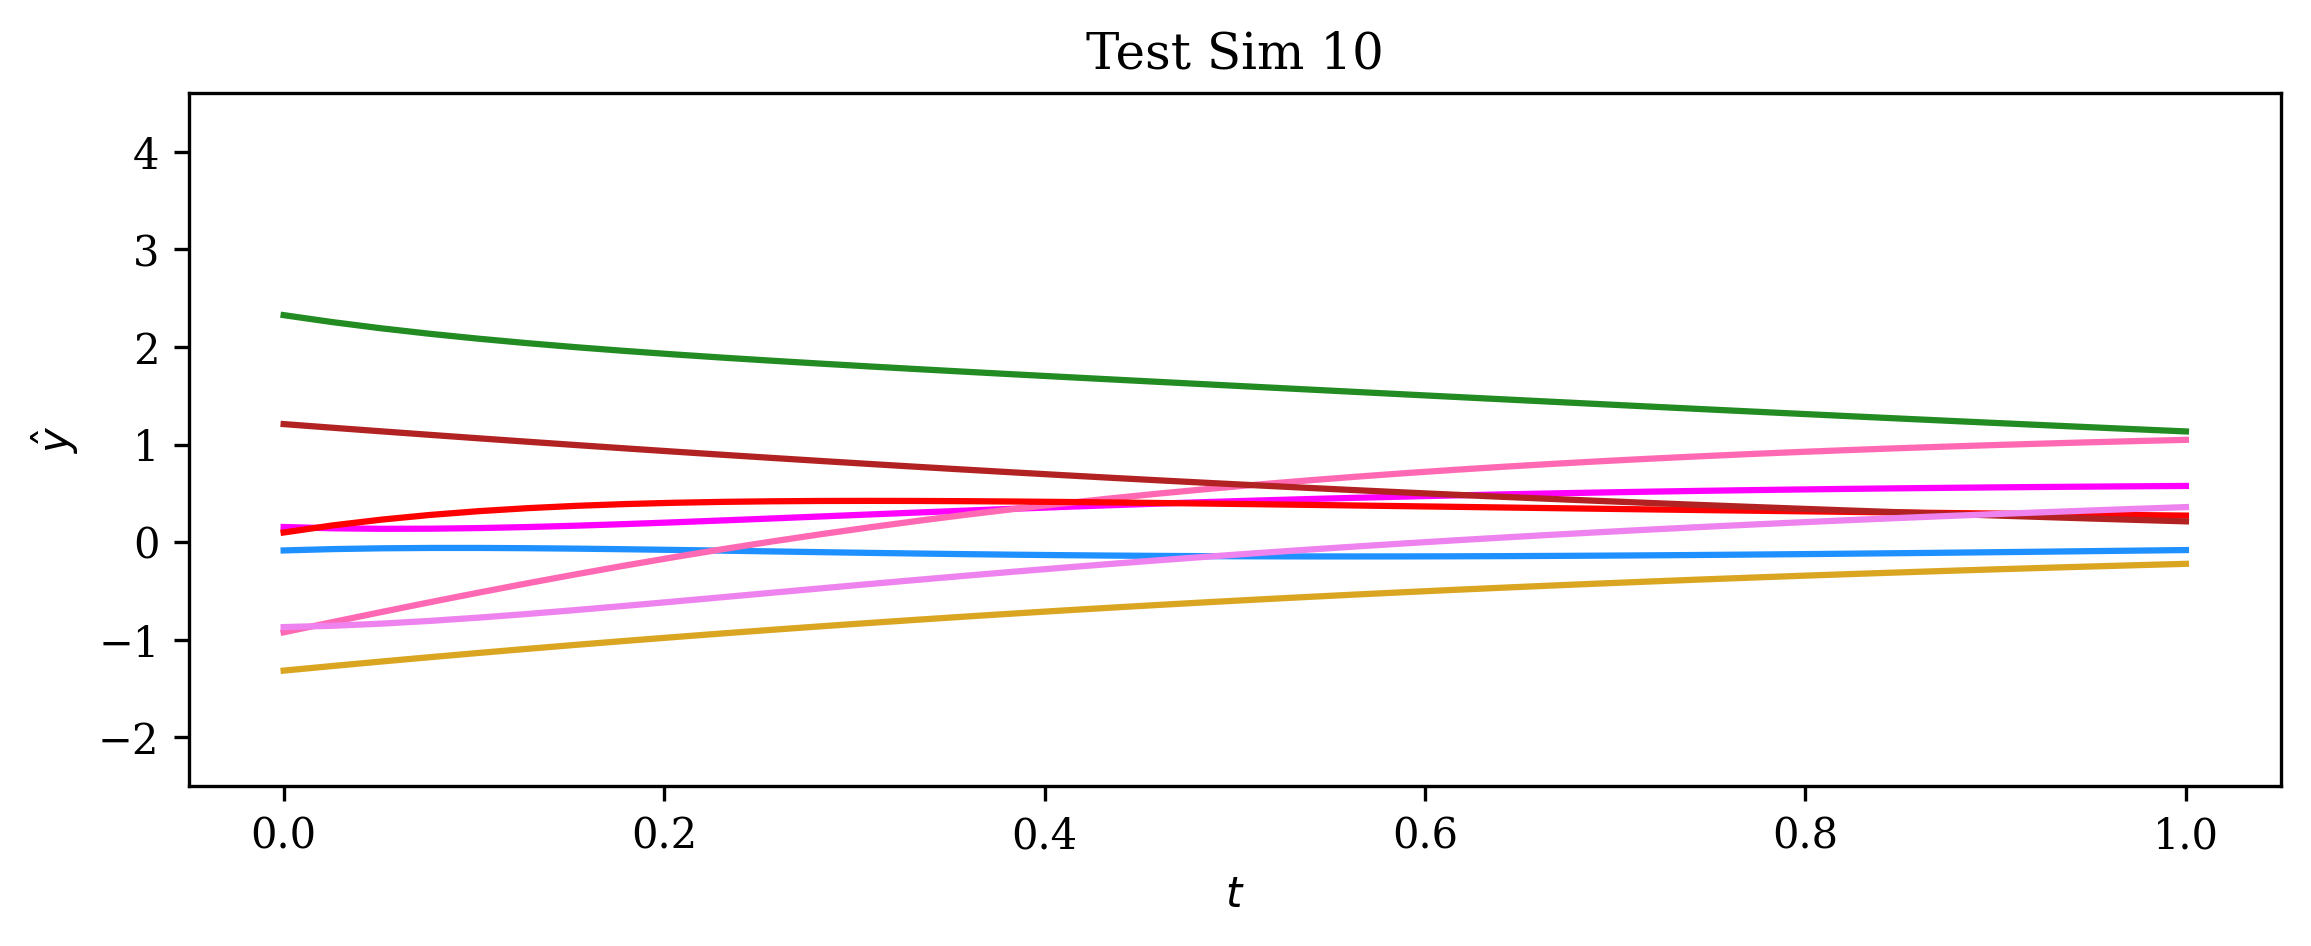

In [104]:
for i in range(1):
    for j in range(9, 10):
        init_preds_i = all_init_preds[i][:, :, j, :8].squeeze(1).cpu().detach().numpy()
        print(init_preds_i.shape)
        fig, ax = plt.subplots()
        # for k, color in enumerate(lat_colors):
        for k in range(8):
            # colored_line(tt, init_preds_i[:, k], 
            #         lat_colors, 
            #         ax,
            #         cmap="plasma")
            
            ax.plot(tt, init_preds_i[:, k], c=colors_lt[k])
            
        ax.set_xlabel(r"$t$")
        ax.set_ylabel(r"$\hat{y}$")
        ax.set_ylim(-2.5, 4.6)
        ax.set_title("Test Sim {:02d}".format(j + 1))

In [77]:
test_dict["observed_data"].shape

torch.Size([1, 22, 1028])

In [105]:
# calculate mean and uncertainty for VPNODE predictions:

n_samples = 500
model.eval()
test_dict = dut.get_next_batch(dut.inf_generator(test_dataloader))

all_preds = torch.zeros(n_samples, 22, 40, 16, 64)

for i in range(n_samples):
    # print("Processing sample ", i)
    lt_test_mu, lt_test_var, raw_test_pred = model(tpredict, test_dict["observed_data"])

    with torch.no_grad():
        test_pred = torch.permute(torch.squeeze(raw_test_pred), (1, 0, 2)) * (trainMax - trainMin) + trainMin

    # test_target = test_dict["data_to_predict"] * (trainMax - trainMin) + trainMin

    # print(test_target.shape)

    test_pred_rs = test_pred.reshape((-1, len(tpredict), 16, 64)).cpu()
    
    all_preds[i, :, :, :, :] = test_pred_rs
    # test_target_rs = test_target.reshape((-1, len(tpredict), 16, 64)).cpu()

In [106]:
mean_preds_vae = torch.mean(all_preds, dim=0)

In [107]:
std_preds_vae = torch.std(all_preds, dim=0)

In [108]:
std_preds_vae.min(), std_preds_vae.max()

(tensor(0.0005), tensor(0.1235))

In [109]:
mean_preds_vae.shape, std_preds_vae.shape

(torch.Size([22, 40, 16, 64]), torch.Size([22, 40, 16, 64]))

In [110]:
trainMin, trainMax

(1.5, 0.8940430879592896)

In [81]:
# test_err_sim.min(), test_err_sim.max()

In [82]:
test_preds_reg_pnode = np.load("./data_surrogate/test_preds_pnode_smoothL1.npy")

In [83]:
import scipy

In [84]:
# test_errs_all = []
# for sim_idx in range(22):
#     test_errs_all.append(

In [85]:
test_params_scaled.shape

(22, 4)

In [86]:
nTimesteps

40

In [87]:
# time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 39])
mean_test_err_t = np.zeros((nTimesteps, test_params_scaled.shape[0]))
for sim_idx in range(test_params_scaled.shape[0]):
    test_err_sim = torch.abs(test_target_rs[sim_idx, :, :, :] - test_pred_rs[sim_idx, :, :])

    # size 40 x 16 x 64 => avg error over a timestep = sum(abs errors pixelwise) / (16 * 64)
    # line plot of length 40 timesteps

    mean_test_err_t[:, sim_idx] = torch.mean(test_err_sim, (1, 2)).cpu().detach().numpy()
    # print(mean_test_err_t.shape)

(0.01, 0.055)

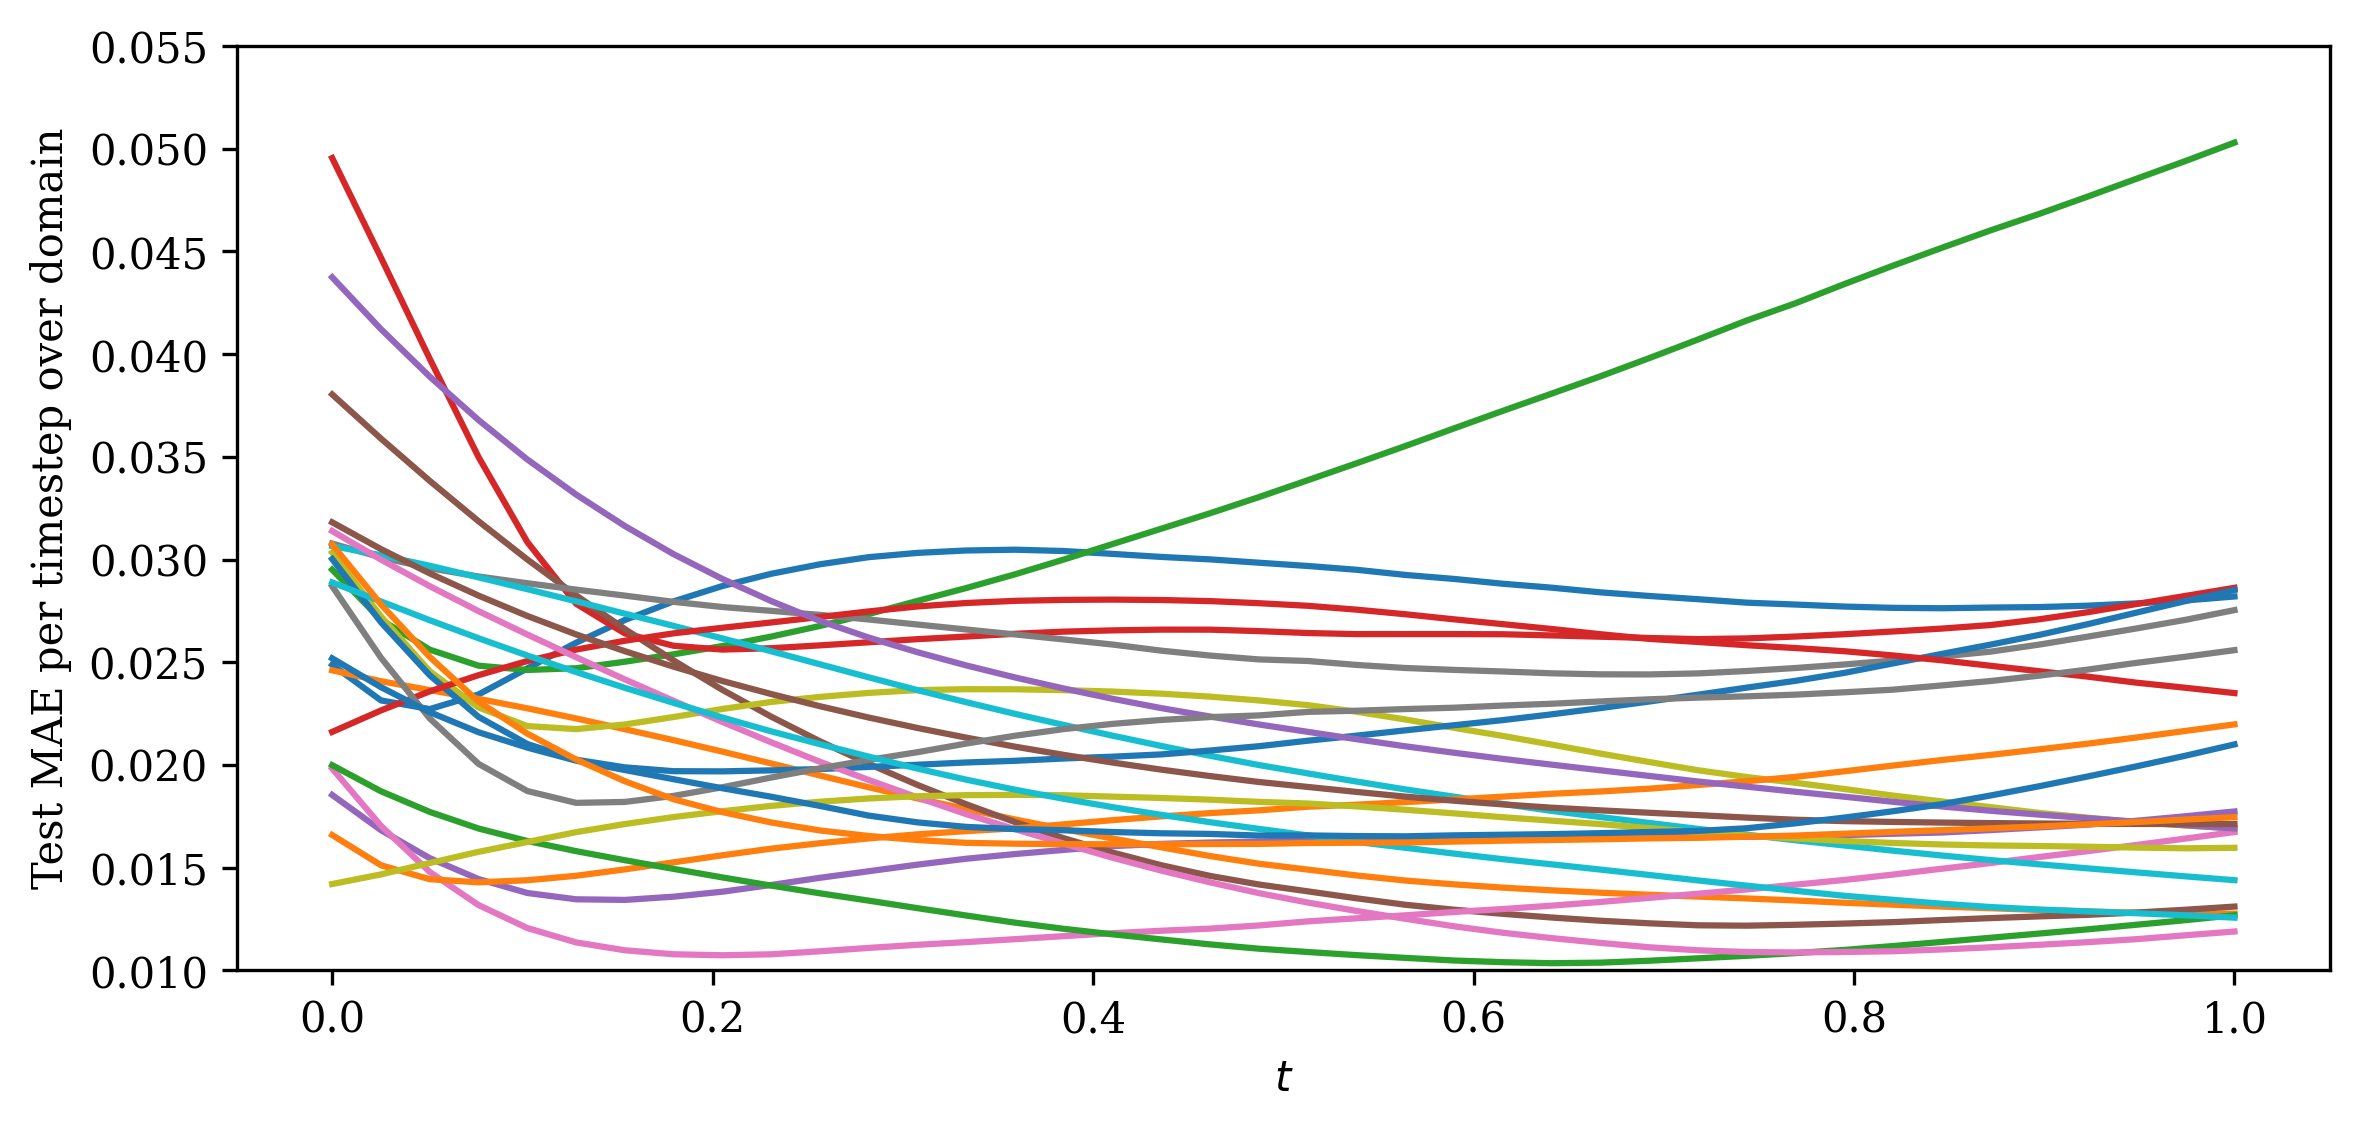

In [91]:
plt.figure(figsize=(9, 4))
plt.plot(tt, mean_test_err_t)
plt.xlabel(r"$t$")
plt.ylabel(r"Test MAE per timestep over domain")
plt.ylim(0.01, 0.055)

In [89]:
mean_test_err_t.min(), mean_test_err_t.max()

(0.010339268483221531, 0.05030268058180809)

Text(0, 0.5, 'Average Relative Test Error Per Timestep')

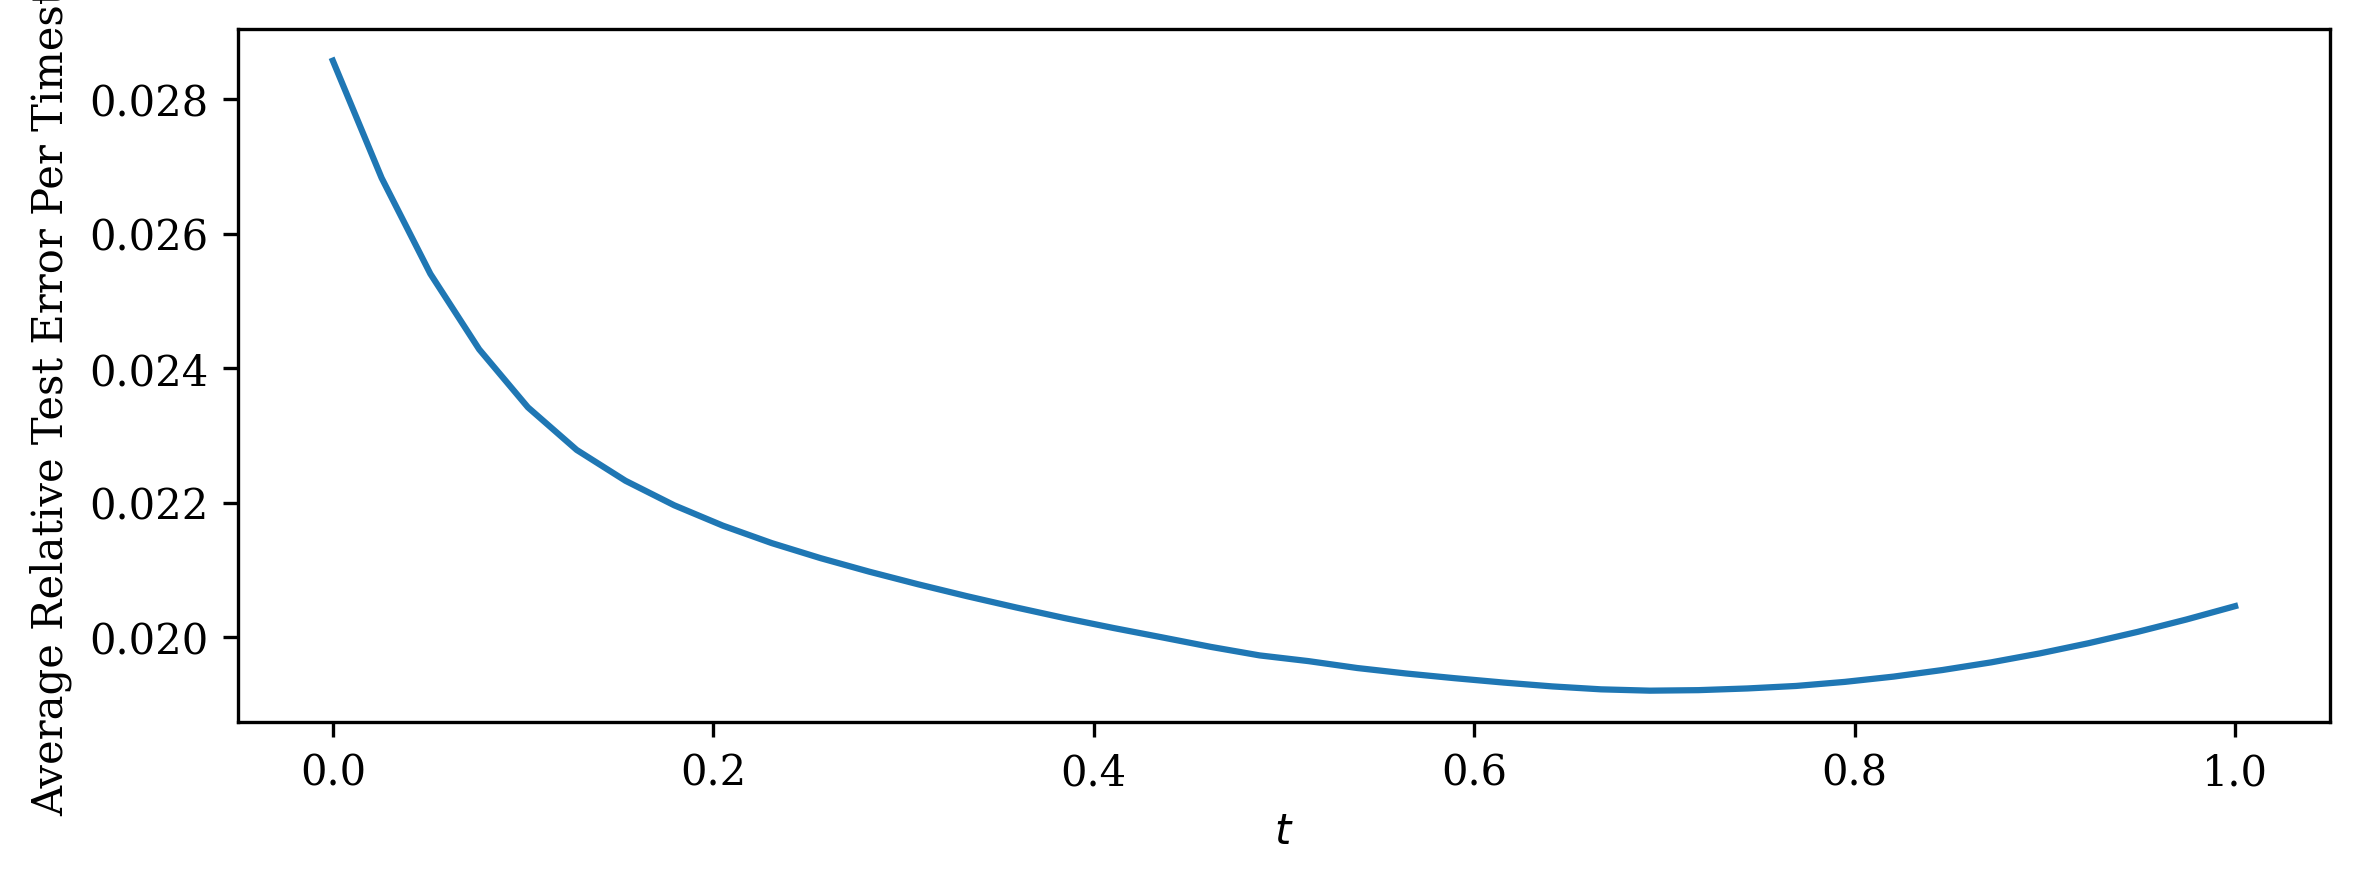

In [98]:
plt.plot(np.linspace(0, 1, nTimesteps), np.mean(mean_test_err_t, axis=1))
plt.xlabel(r"$t$")
plt.ylabel("Average Relative Test Error Per Timestep")

In [112]:
import scipy

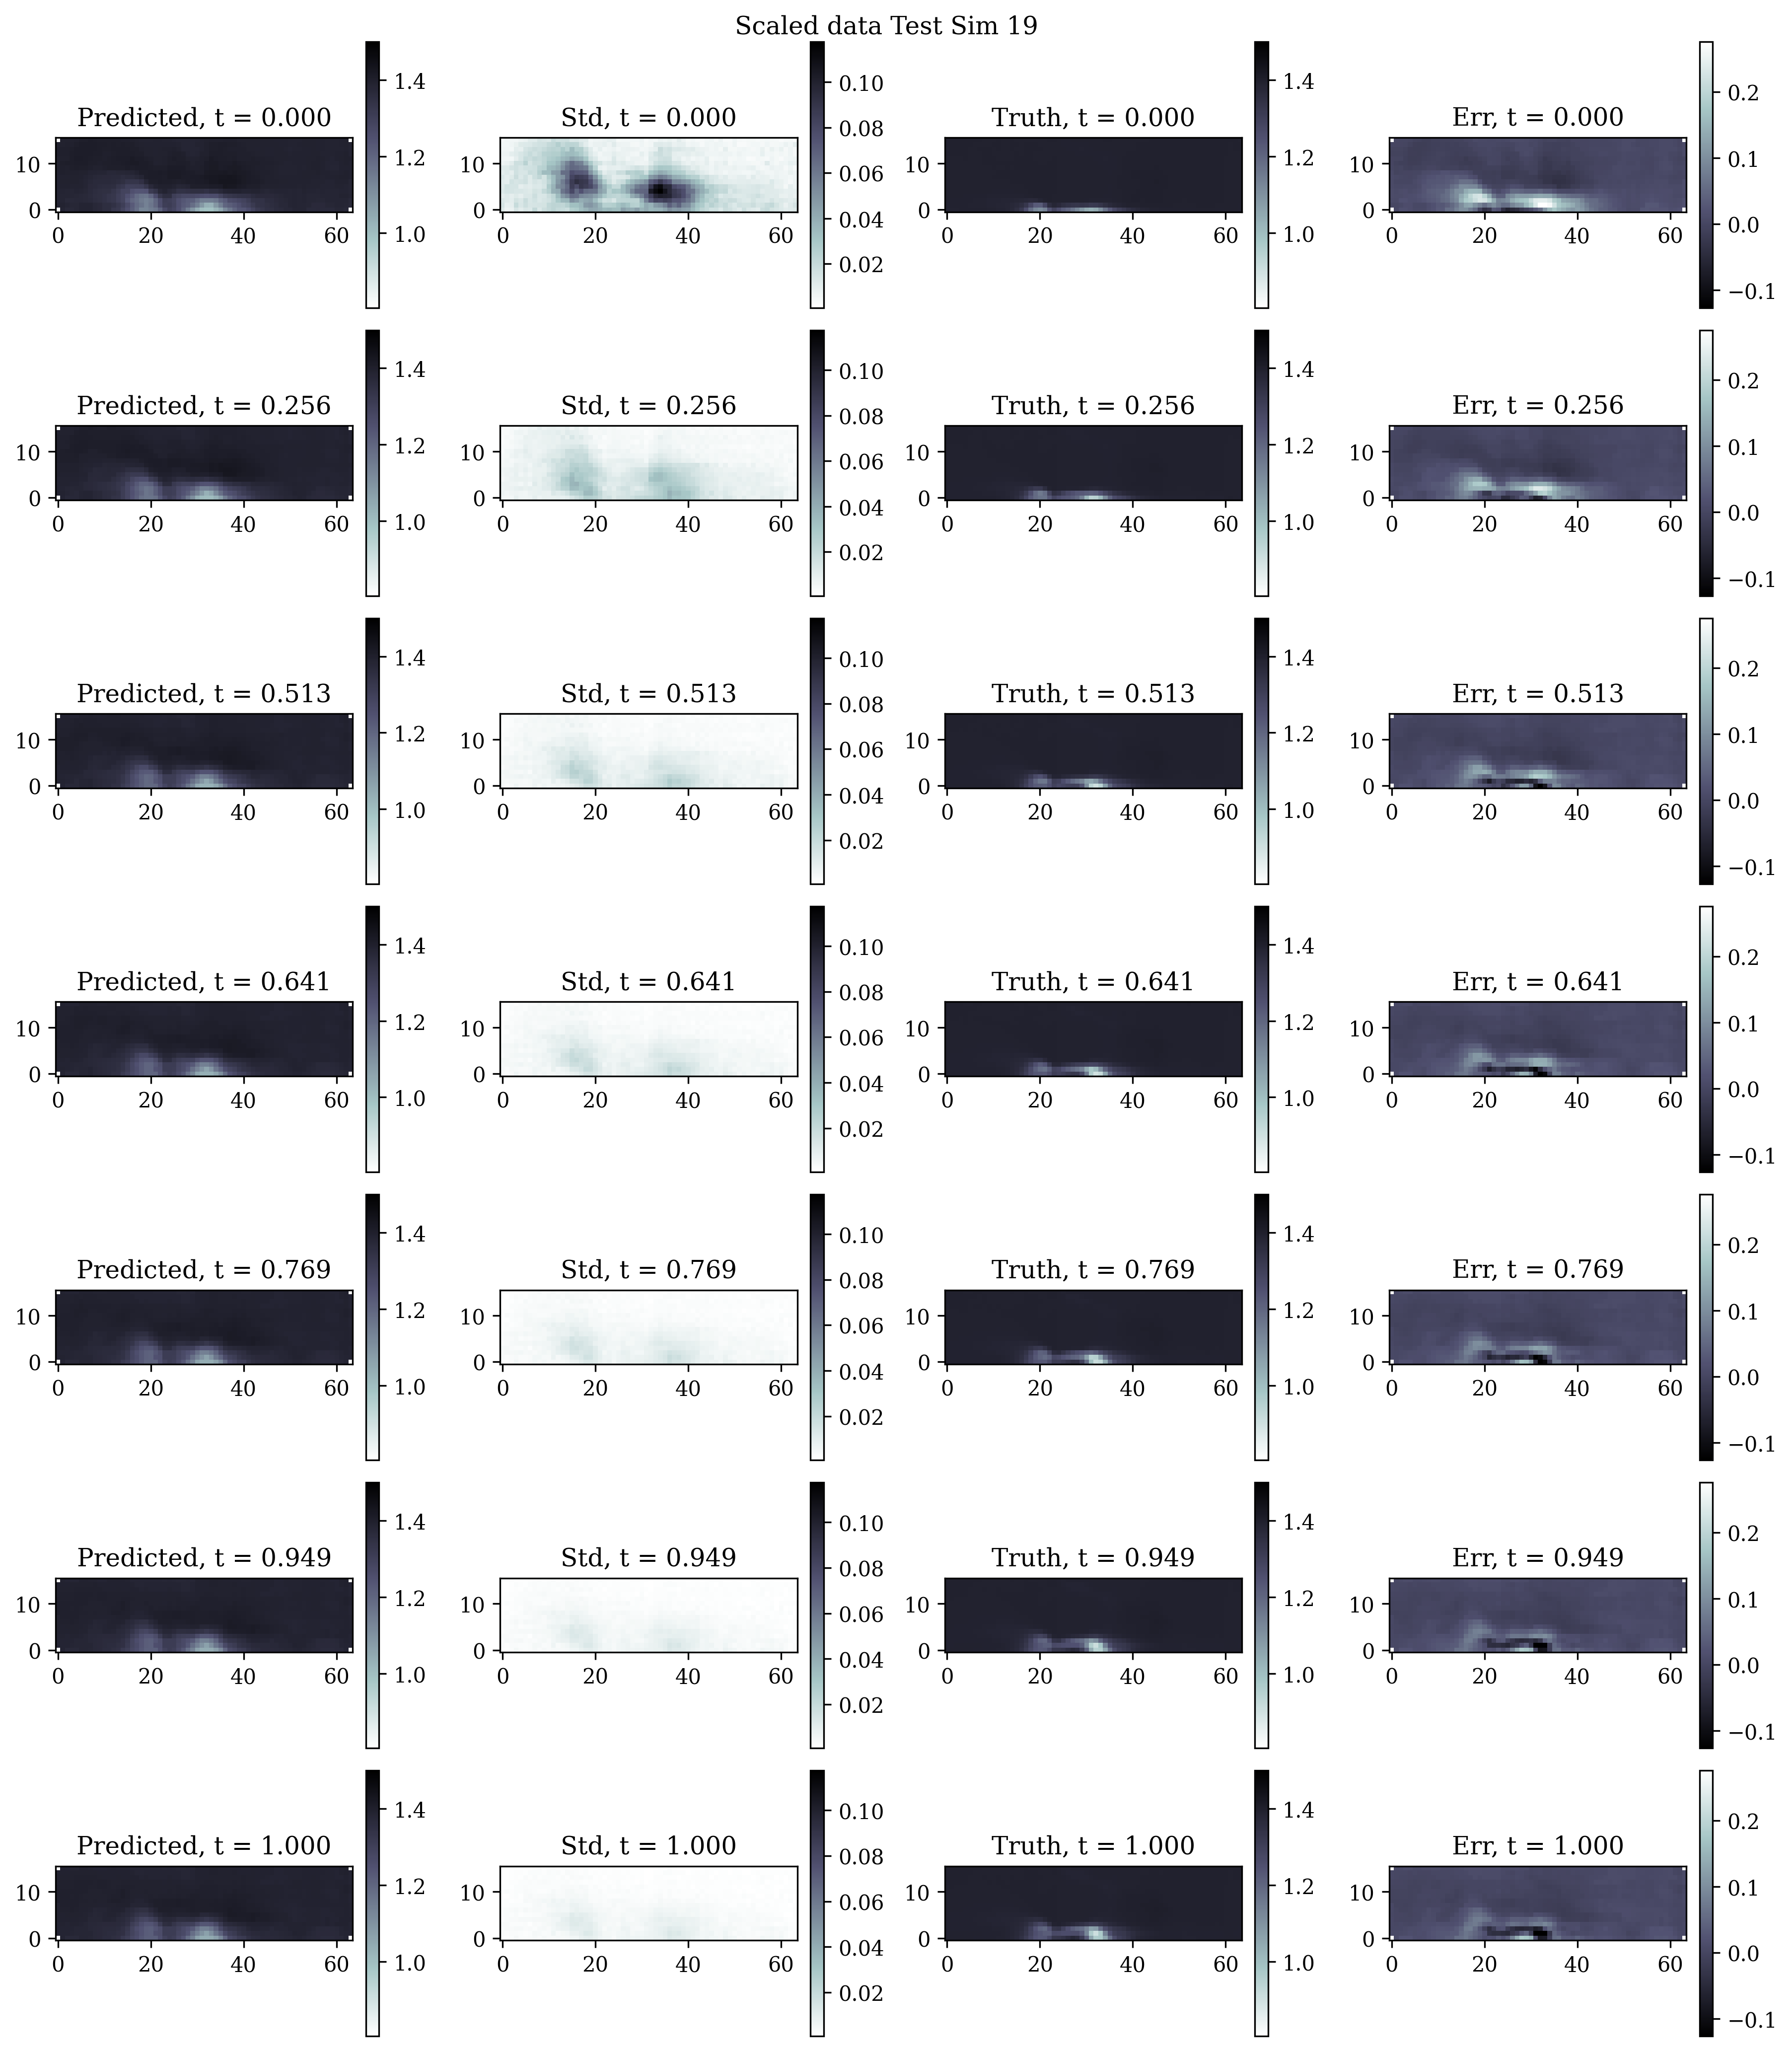

In [114]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 39])
sim_idx = 3

test_err_sim = test_target_rs[sim_idx, :, :, :] - test_pred_rs[sim_idx, :, :]
# print(test_err_sim.shape)

fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(12, 14))

for row in range(7):
    im = axs[row, 0].imshow(scipy.signal.medfilt2d(mean_preds_vae[sim_idx,
                                                               time_idx_to_plot[row],
                                                               :, :]),
                           # test_pred_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Predicted, t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      
for row in range(7):
    im = axs[row, 1].imshow(std_preds_vae[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=std_preds_vae[sim_idx, :, :, :].min().item(),
                           vmax=std_preds_vae[sim_idx, :, :, :].max().item()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Std, t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
        
        
for row in range(7):
    im = axs[row, 2].imshow(test_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Truth, t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 3].imshow(test_target_rs[sim_idx, time_idx_to_plot[row],
                                                                  :, :] -\
                            scipy.signal.medfilt2d(mean_preds_vae[sim_idx,
                                                               time_idx_to_plot[row],
                                                               :, :]),
                           # test_err_sim[time_idx_to_plot[row], :, :],
                            origin="lower",
                            cmap=lc3_reg,
                            vmin=test_err_sim.min(),
                            vmax=test_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 3])
    axs[row, 3].set_title("Err, t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Test Sim {}".format(sim_idx))
fig.tight_layout()

In [ ]:
# Generate many combinations of parameters, show mean and std of those predictions

In [ ]:
import scipy

In [ ]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 39])
sim_idx = 8

test_err_sim = test_target_rs[sim_idx, :, :, :] - test_pred_rs[sim_idx, :, :]


fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(scipy.signal.medfilt2d(test_pred_rs[sim_idx,
                                                               time_idx_to_plot[row],
                                                               :, :]),
                           # test_pred_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3_reg,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Predicted, t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(test_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3_reg,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Truth, t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(test_target_rs[sim_idx, time_idx_to_plot[row],
                                                                  :, :] -\
                            scipy.signal.medfilt2d(test_pred_rs[sim_idx,
                                                               time_idx_to_plot[row],
                                                               :, :]),
                           # test_err_sim[time_idx_to_plot[row], :, :],
                            origin="lower",
                            cmap=lc3_reg,
                            vmin=test_err_sim.min(),
                            vmax=test_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Err, t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Test Sim {}".format(sim_idx))
fig.tight_layout()

In [ ]:
# plt.plot(np.array(train_loss_list))
# plt.plot(np.array(val_loss_list))

In [ ]:
np.array(train_loss_list).shape

In [ ]:
type(train_loss_list)

In [ ]:
plt.plot(train_loss_list[])

In [ ]:
# load data, check min and max timesteps available.